# Decision Trees

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df = pd.read_csv(url, delimiter=',', names=[
    'Class',
    'Alcohol',
    'Malic acid',
    'Ash',
    'Alcalanity of ash',
    'Magnesium',
    'Total phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity',
    'Hue',
    'OD280/OD315 of diluted wines',
    'Proline'])

df.head()

,Class,Alcohol,Malic acid,Ash,Alcalanity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

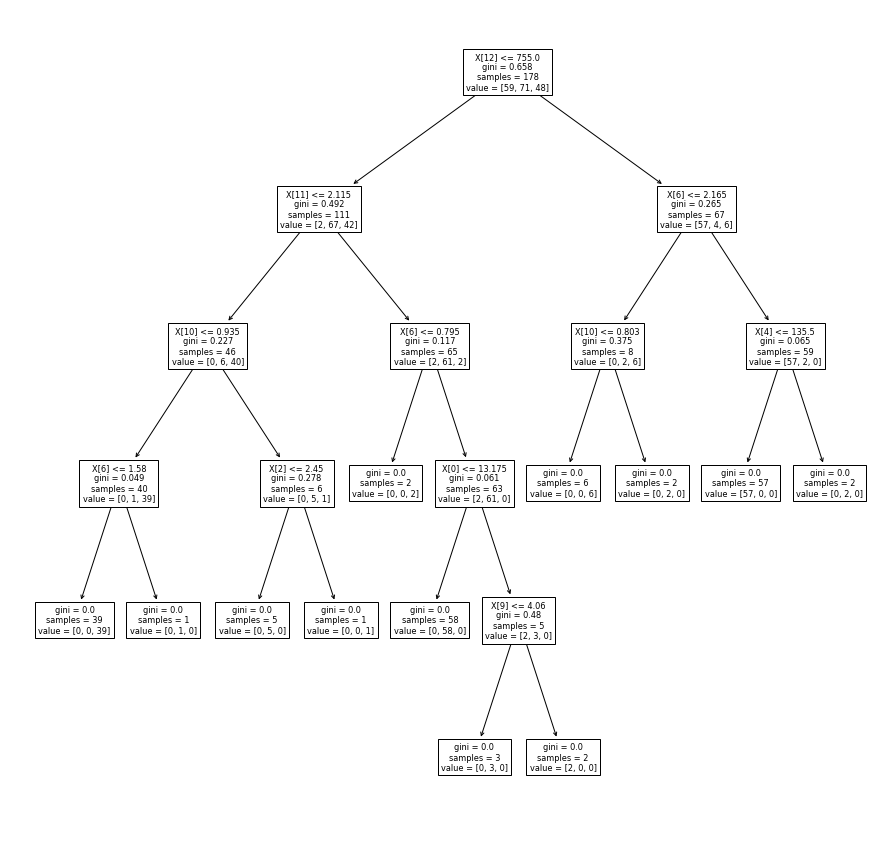

In [11]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)
plt.figure(figsize=(15, 15))
tree.plot_tree(clf);

In [19]:
clf.score(X, y)

1.0

In [20]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X, y, cv=10).mean()

0.8705882352941178

In [37]:
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
clfs[-2].score(X, y)

0.6966292134831461

In [38]:
cross_val_score(clfs[-2], X, y, cv=10).mean()

0.7196078431372549